In [1]:
# import standard libraries
# import third-party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wrds
# import local libraries

In [2]:
# connect to databse and download csv files (run once)
db = wrds.Connection(wrds_username = 'wmartin')
db.create_pgpass_file() # run once

start = '2009-01-01'
end = '2019-12-31'
# download amazon data  
amzn = db.raw_sql("select date, ret"
                  " from crsp.dsf "
                  "where permno in (84788) "
                  "and date>='{}' and date<='{}'".format(start, end))
vwretd = db.raw_sql("select date, vwretd"
                    " from crsp.dsi "
                    "where date>='{}' and date<='{}'".format(start, end), 
                    date_cols=['date'])    
tbill = db.raw_sql("select caldt, tdyld"
                   " from crsp.tfz_dly_rf2 "
                   "where kytreasnox = 2000061 "
                   "and caldt>='{}' and caldt<='{}'".format(start, end))

# to csv
amzn.to_csv('amzn.csv')
vwretd.to_csv('vwretd.csv')
tbill.to_csv('tbill.csv')

Loading library list...
Done
Enter your WRDS username [williammartin]:wmartin
Enter your password:········


In [3]:
# read csv
amzn = pd.read_csv('amzn.csv', usecols = ['ret', 'date'], 
                   index_col = 'date')
vwretd = pd.read_csv('vwretd.csv', usecols = ['vwretd', 'date'], 
                     index_col = 'date')
tbill = pd.read_csv('tbill.csv', usecols = ['tdyld', 'caldt'], 
                    index_col = 'caldt')

Missing values
          ret vwretd  tdyld
count    2772   2772   2772
unique      2      2      2
top     False  False  False
freq     2768   2768   2751
False


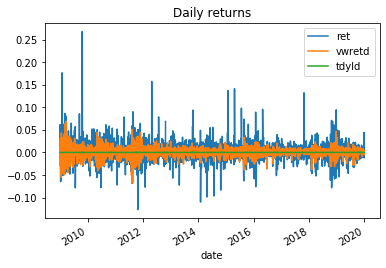

In [4]:
# rename index and turn to datetime
tbill.index = tbill.index.rename('date')
amzn.index = pd.to_datetime(amzn.index)
vwretd.index = pd.to_datetime(vwretd.index)
tbill.index = pd.to_datetime(tbill.index)

# merge
data = pd.concat([amzn, vwretd, tbill], axis = 1)

# plot data 
data.plot(title = 'Daily returns')

print('Missing values')
print(data.isnull().describe())

# forwards fill nan values
data = data.fillna(method = 'ffill')
print(data.isnull().values.any())

# separate risky and riskless
risky = data[['ret', 'vwretd']]
rf = data[['tdyld']]

# compute excess returns
excess_ret = risky.sub(rf['tdyld'], axis = 0)
covariance = excess_ret.cov()
beta = covariance.iloc[0, 1]/covariance.iloc[1, 1]


In [5]:
def computeAndPlot(excess, datatype):

    win = 126
    rolling_cov = excess.rolling(window = win).cov()
    rolling_cov = rolling_cov.xs('ret', level = 1)
    rolling_cov = rolling_cov['vwretd']
    rolling_var = excess['vwretd'].rolling(window = win).var()
    rolling_beta = rolling_cov/rolling_var

    # compute adjusted beta according to Bloomberg formula
    rolling_beta_adj = rolling_beta.apply(lambda x: 2*x/3 + 1/3)

    # compute constant beta
    beta_constant = pd.Series(data = beta, index = rolling_beta.index)

    # plot (question b and d)
    fig, ax = plt.subplots()
    rolling_beta.plot(ax = ax, label = 'Average beta')
    rolling_beta_adj.plot(ax = ax, label = 'Adjusted beta')
    beta_constant.plot(ax = ax, label = 'Constant beta')
    plt.legend()
    plt.title('Beta series of {} data'.format(datatype))

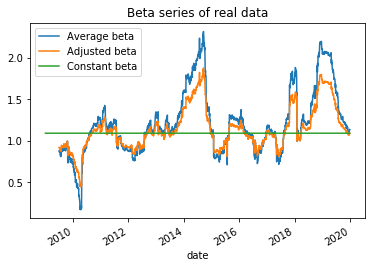

In [6]:
computeAndPlot(excess_ret, 'real')

In [7]:
# question c
excess_ret_mu = excess_ret.mean()
market_total_risk = covariance.iloc[1, 1]
stock_total_risk = covariance.iloc[0, 0]
stock_sys_risk = beta**2*market_total_risk
stock_idi_risk = stock_total_risk - stock_sys_risk

# simulate data
market_sim = excess_ret_mu['vwretd'] + \
             np.random.normal(0, np.sqrt(market_total_risk), len(risky))
int_sim = np.random.normal(0, np.sqrt(stock_idi_risk), len(risky))
stock_sim = beta*(market_sim - rf.mean().values) + int_sim

# create dataframes
market_sim = pd.DataFrame(data = market_sim, index = risky.index)
market_sim = market_sim.rename(columns = {0: 'vwretd'})
stock_sim = pd.DataFrame(data = stock_sim, index = risky.index)
stock_sim = stock_sim.rename(columns = {0: 'ret'})
excess_ret_sim = pd.concat([stock_sim, market_sim], axis = 1)

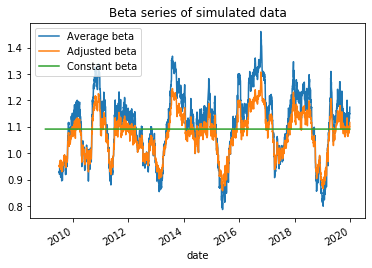

In [8]:
computeAndPlot(excess_ret_sim, 'simulated')